# Menu <a class="anchor" id="menu"></a>

* [1. Les systèmes de recommandation](#intro)
* [2. Analyses exploratoires de `articles_metadata.csv`](#articles_metadata)
* [3. Analyses exploratoires de `clicks_hour_xxx.csv`](#clicks_hour)
* [4. Préparation du jeu de données de travail](#dataset)
    * [4.1 Fusion de `articles_metadata.csv` et `clicks_hour_xxx.csv`](#dataset_merge)
    * [4.2 Nettoyage du jeu de données](#dataset_clean)
    * [4.3 Conception d'une feature de scoring](#dataset_score)

# Préparatifs 

In [1]:
import pickle
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm  #, uniform

random_seed = 0
np.random.seed(random_seed)

In [2]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, log_scale=False, show_grid=False, x_label=None, y_label="Nombre d'articles"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    if log_scale:
        ax.set_yscale('log')
    if show_grid:
        plt.grid(visible=True, which='major', axis='y')
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [3]:
def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(f'----- UNIVARIATE ANALYSIS for "{col_name}" -----\n',dt.describe(),'\n', sep='\n')

    fig = plt.figure(figsize=(15, 8))

    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")

    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot for {col_name}")
    qqplot(data[data[col_name].notnull()][col_name], norm, fit=True, line="45", ax=ax)

    ###  Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null

    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null, total_size_nonull]), labels=["", ""], autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Distribution between rows with and without '{col_name}' values")
    plt.legend(["MISSING"], loc='lower center', bbox_to_anchor=(0, 0))

    fig.tight_layout()
    plt.show()

    print(f"'{col_name}' is missing {total_size_null} over {total_size} ({percent_v:.2f}%)")

---
---
# 1. Les sytèmes de recommandation <a class="anchor" id="intro"></a> [⇪](#menu)

> Le but des systèmes de recommandation est de chercher des similarités entre utilisateurs ou éléments à recommander (livres, films, articles, vétements...) sur la base d'indicateurs permettant de définir de manière implicite ou explicite le degré de satisfaction lié à ces éléments. Une fois les éléments similaires identifiés, on peut recommander les X premiers ou tirer au hasard dans les X premiers etc.

<img src='medias/recommender_matrix.png' width=700>

> ### Dans les systèmes de recommandation, on a 3 approches généralement admises:
> 1. Collaborative Filtering
> 2. Content-based Filtering
> 3. Hybrid recommenders

<img src='medias/collaborative_vs_content_filtering.png' width=700>

> **Collaborative Filtering**<br>
> Le filtrage collaboratif est un ensemble de méthodes qui se basent uniquement sur *les interactions entre les utilisateurs et les éléments* qui ont été enregistrées, afin de produire de nouvelles recommandations.<br>
> <img src='medias/collaborative_filtering.png' width=700>
>
> 1. **Memory Based**
>    * **User-based or user-user collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **utilisateurs** similaires sur la base des évaluations qu'ils ont donné.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*
>    * **Item-based or item-item collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **articles** similaires sur la base des évaluations que leur attribuent les utilisateurs.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*<br><br>
> 2. **Model Based**
>    * **Matrix factorization**<br>
>        cette approche qui est la principale solution des model based, peut être considéré comme la décomposition d'une grande matrice en un produit de plus petites matrices. Le nombre de ces facteurs peut aller de un à des centaines, voire des milliers.<br>
>        Le nombre de facteurs latents est l'un des éléments qui doivent être optimisés pendant la formation du modèle. <br>
>        Le nombre de facteurs latents affecte les recommandations d'une manière telle que plus le nombre de facteurs est élevé, plus les recommandations sont personnalisées. Mais un trop grand nombre de facteurs peut conduire à un surajustement du modèle.
>
>        Il existe plusieurs algorithmes pouvant correspondre à cette approche:
>        * SVD / SVD++
>        * PCA / NMF
>        * Autoencoders (Neural Networks)

> **Content-based Filtering**<br>
> L'approche basée sur le contenu utilise des informations disponibles *(en plus des scores)* sur les utilisateurs et/ou les articles. Dans ce cas, on utilise donc les caractéristiques des articles pour recommander d'autres articles similaires à ceux que l'utilisateur aime, mais en s'appuyant également sur les actions précédentes, des commentaires, ou d'autres infos disponibles.<br>
> <img src='medias/content_filtering.png' width=700>

> **Hybrid recommenders**<br>
> Un système de recommandation hybride est un type particulier de système de recommandation qui peut être considéré comme la combinaison entre le *Collaborative Filtering* et le *Content-based Filtering*.



---
---
# 2. Analyses exploratoires de `articles_metadata.csv` <a class="anchor" id="articles_metadata"></a> [⇪](#menu)

> articles_metadata.csv - CSV file with metadata information about all (364047) published articles 

In [4]:
data_articles = pd.read_csv('data/news-portal-user-interactions-by-globocom/articles_metadata.csv')
display(data_articles.sample(5), data_articles.shape)

article_id  category_id  created_at_ts  publisher_id  words_count
181932      181932          301  1507649455000             0          182
6245          6245            6  1417690563000             0          202
313837      313837          431  1515781621000             0          235
171070      171070          299  1459502786000             0          158
97803        97803          216  1437024112000             0          181

(364047, 5)

>#### Ce sont les informations permettant de décrire les articles *(nous n'avons accès ni aux titres ni aux textes des articles)*
> - `article_id` est le code d'identification unique de chaque article publié
> - `category_id` est le code d'identification unique de la catégorie à laquelle apprtient l'article
> - `created_at_ts` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'article à été publié
> - `publisher_id` est le code d'identification unique de l'éditeur de l'article *(j'imagine que c'est prévu pour pouvoir s'ouvrir à d'autres éditeurs si ce n'est pas encore le cas)*
> - `words_count` est nombre de mots présents dans l'article
>
> Ce jeu de données est composé de **364K articles** décrites par **5 variables**

## 2.1 Vérifications de base <a class="anchor" id="articles_metadata_uni"></a> [⇪](#menu)

In [5]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


### Vérifions les valeurs *(min, max, mean etc.)*

In [6]:
pd.set_option('float_format', '{:.0f}'.format)

In [7]:
data_articles.describe(include='number').T

count          mean         std           min           25%  \
article_id    364047        182023      105091             0         91012   
category_id   364047           283         137             0           199   
created_at_ts 364047 1474070237328 42930380229 1159355675000 1444924843500   
publisher_id  364047             0           0             0             0   
words_count   364047           191          60             0           159   

                        50%           75%           max  
article_id           182023        273034        364046  
category_id             301           399           460  
created_at_ts 1489422449000 1509890951000 1520943150000  
publisher_id              0             0             0  
words_count             186           218          6690

In [8]:
# pd.reset_option('float_format')
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> - ⚠️ `created_at_ts` : les dates vont du **27/09/2006 11:14:35 GMT au 13/03/2018 12:12:30 GMT**, alors que le jeu de données est décrit comme allant du  **01/10/2017 au 16/10/2017**. Donc même si l'on considère que les articles peuvent être plus vieux que les click utilisateurs, il est peu probable qu'un article de 2018 trouve légitimment sa place dans notre jeu de données.
>
> - ⚠️ `words_counts` : la taille des articles varie de **0 à 6690**... Un article de 0 mots n'a aucun sens, et 6690 est très au dessus de la moyenne de 186 mots ou même du 3ème quartile de 218 mots.
>

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `article_id` : chaque article possède bien un ID unique
> - `category_id` : on constate qu'il y a 461 catégories d'articles, mais il n'y a pas de raison de croire que c'est un problème.
> - `publisher_id` : on constate qu'il y a 1 seul éditeur, mais c'est tout à fait attendu (on peut imaginer que seul l'équipe de Globo.com peut publier sur Globo.com)

### Doublons

#### Regardons si il y des articles en double sur la base de la colonnes `article_id`

In [9]:
data_articles.duplicated(subset=['article_id']).sum()

0

### Regardons plus en détails la colonne `created_at_ts`

----- UNIVARIATE ANALYSIS for "created_at_ts" -----

count          364047.00
mean    1474070237328.42
std       42930380228.81
min     1159355675000.00
25%     1444924843500.00
50%     1489422449000.00
75%     1509890951000.00
max     1520943150000.00
Name: created_at_ts, dtype: float64




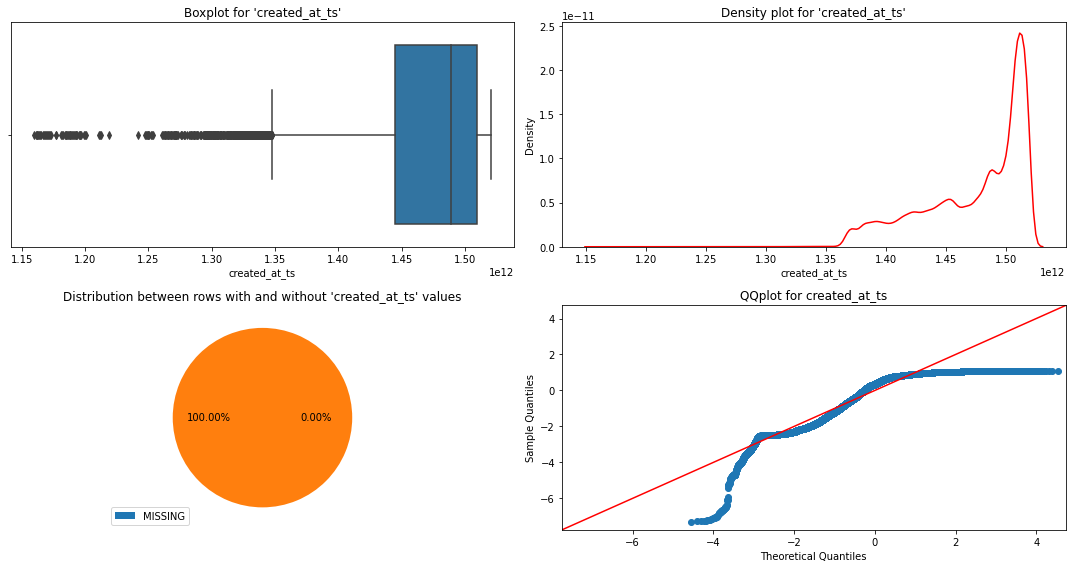

'created_at_ts' is missing 0 over 364047 (0.00%)


In [10]:
explore_quantitative(data_articles, 'created_at_ts')

### Regardons plus en détails la colonne `words_count`

----- UNIVARIATE ANALYSIS for "words_count" -----

count   364047.00
mean       190.90
std         59.50
min          0.00
25%        159.00
50%        186.00
75%        218.00
max       6690.00
Name: words_count, dtype: float64




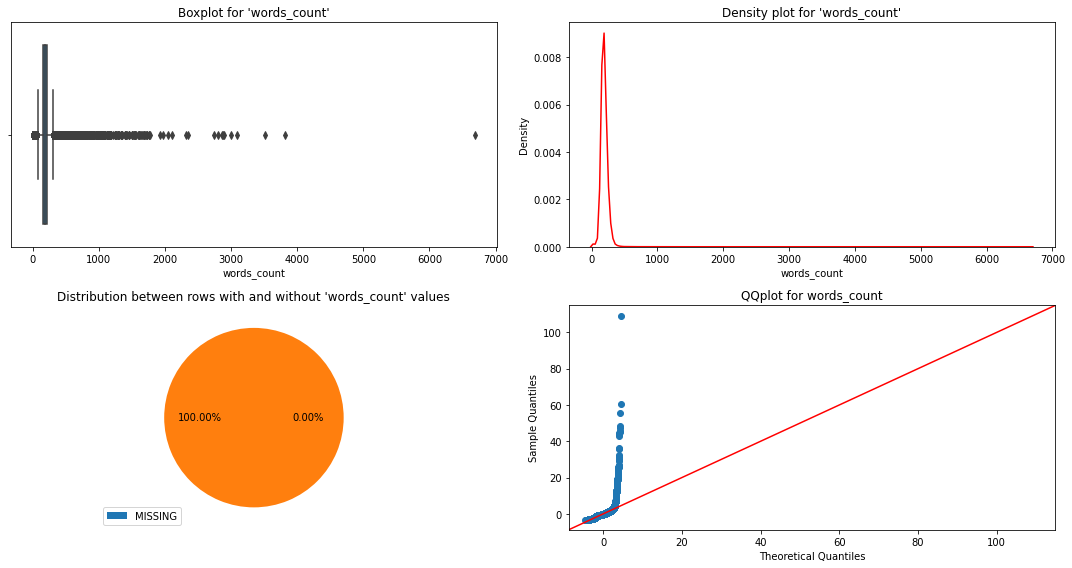

'words_count' is missing 0 over 364047 (0.00%)


In [11]:
explore_quantitative(data_articles, 'words_count')

## 2.2 Analyses multivariées <a class="anchor" id="articles_metadata_multi"></a> [⇪](#menu)

### Regardons la repartition des articles dans le temps

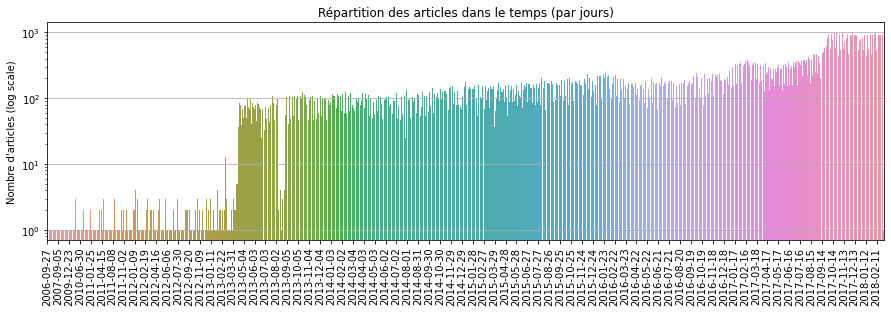

In [12]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des articles dans le temps (par jours)", 
    y_label="Nombre d'articles (log scale)",
    labels_modulo=30, show_values=False, log_scale=True, show_grid=True,
)

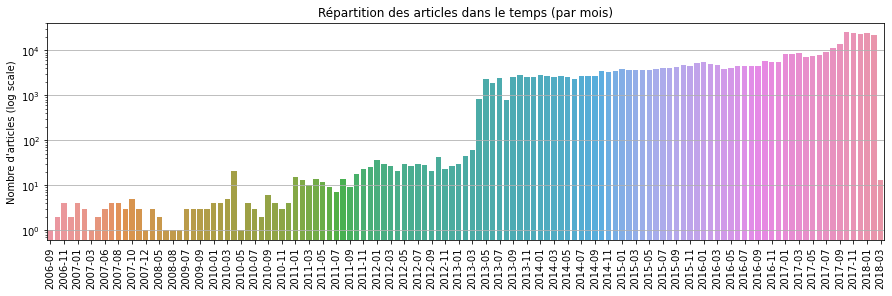

In [13]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des articles dans le temps (par mois)", 
    y_label="Nombre d'articles (log scale)",
    labels_modulo=2, show_values=False, log_scale=True, show_grid=True,
)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les articles dont les valeurs sont plus récentes que le plus récent des clicks ?<br>(où vont ils être naturellement éliminés losque l'on ne va retenir que les articles aillant reçu un minimum de clicks ?)
> - ❌ Supprimer la colonne `publisher_id` qui ne présente qu'une unique valeur.
> - ❌ Supprimer les articles qui ne sont pas utilisés dans le jeu de données clicks_hour.zip

---
---
# 3. Analyses exploratoires de `clicks_hour_XXX.csv` <a class="anchor" id="clicks_hour"></a> [⇪](#menu)
> clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

## 3.1 Concatenate all clicks CSV files <a class="anchor" id="clicks_hour_concat"></a> [⇪](#menu)

clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

In [14]:
datalist = []
for i in range(0, 385):
    data_tmp = pd.read_csv(f'data/news-portal-user-interactions-by-globocom/clicks/clicks_hour_{i:03}.csv')
    data_tmp['hour'] =  i
    datalist.append(data_tmp)

data_clicks = pd.concat(datalist)
display(data_clicks.head(), data_clicks.shape)

user_id        session_id  session_start session_size click_article_id  \
0       0  1506825423271737  1506825423000            2           157541   
1       0  1506825423271737  1506825423000            2            68866   
2       1  1506825426267738  1506825426000            2           235840   
3       1  1506825426267738  1506825426000            2            96663   
4       2  1506825435299739  1506825435000            2           119592   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506826828020                 4                 3       20             1   
1   1506826858020                 4                 3       20             1   
2   1506827017951                 4                 1       17             1   
3   1506827047951                 4                 1       17             1   
4   1506827090575                 4                 1       17             1   

  click_region click_referrer_type  hour  
0           20                   2     0  
1           20                   2     0  
2           16                   2     0  
3           16                   2     0  
4           24                   2     0

(2988181, 13)

>#### Ce sont les informations permettant de décrire les interactions utilisateur sur le site Globo.com
> - `user_id` est le code d'identification unique de chaque utilisateur du site
> - `session_id` est le code d'identification unique de chaque session utilisateur *(chaque session peut avoir plusieurs interactions, donc être présente plusieurs fois)*
> - `session_start` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à commencé sa session sur le site
> - `session_size` est le nombre d'interactions enregistrées dans la session associée
> - `click_article_d` est le code d'identification unique de l'article auquel mène le click
> - `click_timestamp` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à clické pour visiter l'article associé
> - `click_environment` est ❓
> - `click_deviceGroup` est ❓
> - `click_os` est *probablement un code d'identification lié aux différents operating systems et leurs déclinaisons* ❓
> - `click_country` est le code d'identification unique de chaque pays (le 1 semble être le Brézil)
> - `click_region` est le code d'identification unique de chaue région du pays associé
> - `click_referrer` est *probablement le code d'identification du site d'où vient le click* ❓
> - `hour` est l'identifiant du CSV d'origine contenu dans clicks.zip *(clicks_hour_{HOUR}.csv)*
>
> Ce jeu de données est composé de **299K interactions** décrites par **13 variables**

## 3.2 Vérifications de base <a class="anchor" id="clicks_hour_uni"></a> [⇪](#menu)

In [15]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
 12  hour                 int64 
dtypes: int64(1), object(12)
memory usage: 319.2+ MB


### Ajustons les types de colonnes pour faciliter le travail d'analyse

In [16]:
#for col in ['user_id', 'session_id', 'click_article_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']:
for col in ['click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']:
    data_clicks[col] = data_clicks[col].astype('category')
    
for col in ['user_id', 'session_id', 'click_article_id', 'session_start', 'click_timestamp', 'session_size']:
    data_clicks[col] = data_clicks[col].astype('int64')

In [17]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype   
---  ------               -----   
 0   user_id              int64   
 1   session_id           int64   
 2   session_start        int64   
 3   session_size         int64   
 4   click_article_id     int64   
 5   click_timestamp      int64   
 6   click_environment    category
 7   click_deviceGroup    category
 8   click_os             category
 9   click_country        category
 10  click_region         category
 11  click_referrer_type  category
 12  hour                 int64   
dtypes: category(6), int64(7)
memory usage: 199.5 MB


### Vérifions les valeurs *(min, max, mean etc.)*

In [18]:
pd.set_option('float_format', '{:.0f}'.format)

In [19]:
data_clicks.describe(include='number').T

count             mean          std              min  \
user_id          2988181           107948        83648                0   
session_id       2988181 1507472228344485 385524460231 1506825423271737   
session_start    2988181    1507472228013    385524460    1506825423000   
session_size     2988181                4            4                2   
click_article_id 2988181           194923        90768                3   
click_timestamp  2988181    1507474265606    385850960    1506826800026   
hour             2988181              179          107                0   

                              25%              50%              75%  \
user_id                     40341            86229           163261   
session_id       1507124152253606 1507493340299445 1507749414106993   
session_start       1507124152000    1507493340000    1507749414000   
session_size                    2                3                4   
click_article_id           124228           202381           277067   
click_timestamp     1507126852854    1507494930481    1507751004601   
hour                           82              185              256   

                              max  
user_id                    322896  
session_id       1508211379189330  
session_start       1508211379000  
session_size                  124  
click_article_id           364046  
click_timestamp     1510603454886  
hour                          384

In [20]:
data_clicks.describe(exclude='number').T

count  unique  top     freq
click_environment    2988181       3    4  2904478
click_deviceGroup    2988181       5    1  1823162
click_os             2988181       8   17  1738138
click_country        2988181      11    1  2852406
click_region         2988181      28   25   804985
click_referrer_type  2988181       7    2  1602601

In [21]:
# pd.reset_option('float_format')
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> * `session_start`: les dates vont du **01/10/2017 02:37:03 GMT au 17/10/2017 03:36:19 GMT**.
> * `click_timestamp`: les dates vont du **01/10/2017 03:00:00 GMT au 13/11/2017 20:04:14 GMT**.
> <br>⚠️ On a donc une session qui a duré au minimum 27 jours *(17/10 -> 13/11)*.
> * `user_id` : certains utilisateurs semblent avoir un nombre de session très au dessus de la moyenne. Est-ce un problème ❓
> - `session_size` : la taille des sessions varie de **2 à 124**... 124 semble très au dessus du troisième quartile qui est à 4.

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `session_id` : la session la plus fréquente (124) correspond au nombre maximum de session_size (124) et le reste semble cohérent.
> - `click_article_id` : seuls **46033 des 364047 articles sont utilisés**, mais ça ne pose pas de problème.
> - `click_environment` : on a visiblement 3 environnements (web/ios/android ?) pris en compte. Rien d'anormal.
> - `click_deviceGroup`, `click_os`, `click_country`, `click_region`, `click_referrer_type` ont toutes des valeurs qui semblent raisonnables même si l'on considère que l'on ne sait pas toujours exactement ce qu'elles représentent.


### Regardons plus en détails la colonne `session_start`

short_date     2017-10-01  2017-10-02  2017-10-03  2017-10-04  2017-10-05  \
count            75205.00   290443.00   282762.00   210182.00   190898.00   
count_percent        2.52        9.72        9.46        7.03        6.39   

short_date     2017-10-06  2017-10-07  2017-10-08  2017-10-09  2017-10-10  \
count           207027.00   147253.00   104685.00   242356.00   282524.00   
count_percent        6.93        4.93        3.50        8.11        9.45   

short_date     2017-10-11  2017-10-12  2017-10-13  2017-10-14  2017-10-15  \
count           242362.00   123316.00   183344.00    99641.00    84054.00   
count_percent        8.11        4.13        6.14        3.33        2.81   

short_date     2017-10-16  2017-10-17  
count           192185.00    29944.00  
count_percent        6.43        1.00

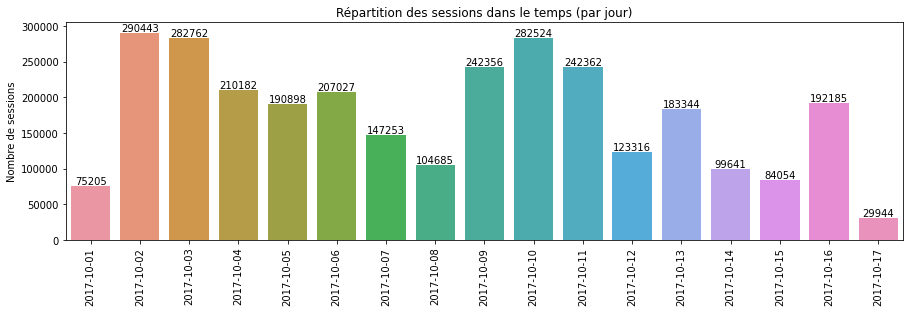

In [22]:
selection = data_clicks[['session_id', 'session_start']].copy()
selection['short_date'] = selection['session_start'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count'])

selection["count_percent"] = 100 / selection['count'].sum() * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des sessions dans le temps (par jour)", 
     y_label='Nombre de sessions',
    labels_modulo=1, show_values=True,
)

### Regardons plus en détails la colonne `click_timestamp`

short_date     2017-10-01  2017-10-02  2017-10-03  2017-10-04  2017-10-05  \
count            72106.00   286952.00   285219.00   210454.00   190165.00   
count_percent        2.41        9.60        9.54        7.04        6.36   

short_date     2017-10-06  2017-10-07  2017-10-08  2017-10-09  2017-10-10  \
count           207840.00   147946.00   104423.00   240519.00   283115.00   
count_percent        6.96        4.95        3.49        8.05        9.47   

short_date     ...  2017-10-26  2017-10-27  2017-10-28  2017-10-30  \
count          ...       12.00        8.00        2.00       12.00   
count_percent  ...        0.00        0.00        0.00        0.00   

short_date     2017-10-31  2017-11-01  2017-11-03  2017-11-04  2017-11-07  \
count                4.00        6.00        2.00        2.00        2.00   
count_percent        0.00        0.00        0.00        0.00        0.00   

short_date     2017-11-13  
count                2.00  
count_percent        0.00  

[2 rows x 35 columns]

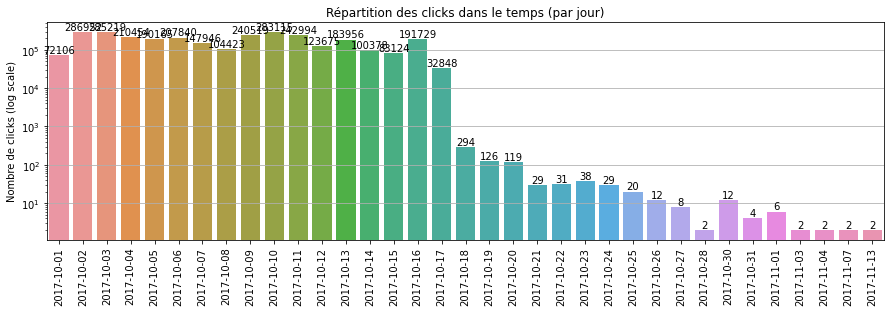

In [23]:
selection = data_clicks[['session_id', 'click_timestamp']].copy()
selection['short_date'] = selection['click_timestamp'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count'])

selection["count_percent"] = 100 / selection['count'].sum() * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des clicks dans le temps (par jour)", 
    y_label='Nombre de clicks (log scale)',
    labels_modulo=1, show_values=True, log_scale=True, show_grid=True, 
)

> #### ⚠️ On note que les dates de clicks s'étendent bien au dela des dates de début de session *(on des clicks presque 1 mois après le dernier début de session enregistré)*

## 3.3 Analyses multivariées <a class="anchor" id="clicks_hour_multi"></a> [⇪](#menu)

### Regardons le nombre d'articles lus par utilisateurs

num_articles           2        3        4        5        6        7     \
num_users         101428.00 22660.00 38432.00 18070.00 20370.00 13358.00   
num_users_percent     31.41     7.02    11.90     5.60     6.31     4.14   

num_articles          8       9       10      11    ...  501   502   513   \
num_users         12780.00 9701.00 8807.00 7143.00  ...  1.00  1.00  1.00   
num_users_percent     3.96    3.00    2.73    2.21  ...  0.00  0.00  0.00   

num_articles       529   722   746   783   900   939   1232  
num_users          1.00  1.00  1.00  1.00  1.00  1.00  1.00  
num_users_percent  0.00  0.00  0.00  0.00  0.00  0.00  0.00  

[2 rows x 302 columns]

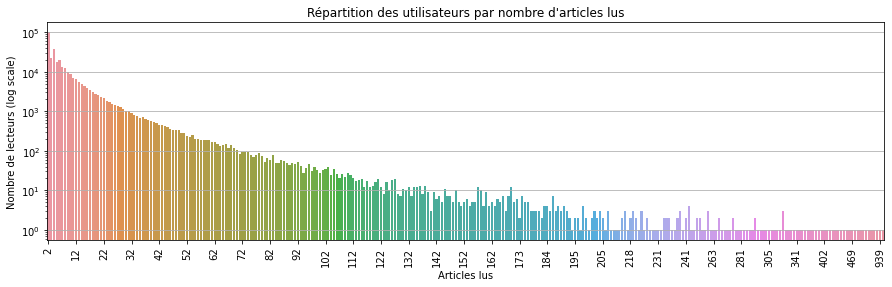

In [24]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus", 
    x_label="Articles lus", y_label="Nombre de lecteurs (log scale)",
    labels_modulo=10, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

num_articles             2        3        4        5        6        7   \
num_users         101428.00 22660.00 38432.00 18070.00 20370.00 13358.00   
num_users_percent     31.41     7.02    11.90     5.60     6.31     4.14   

num_articles            8       9       10      11  ...      17      18  \
num_users         12780.00 9701.00 8807.00 7143.00  ... 3458.00 3040.00   
num_users_percent     3.96    3.00    2.73    2.21  ...    1.07    0.94   

num_articles           19      20      21      22      23      24      25  \
num_users         2755.00 2557.00 2281.00 2120.00 1864.00 1725.00 1554.00   
num_users_percent    0.85    0.79    0.71    0.66    0.58    0.53    0.48   

num_articles           26  
num_users         1487.00  
num_users_percent    0.46  

[2 rows x 25 columns]

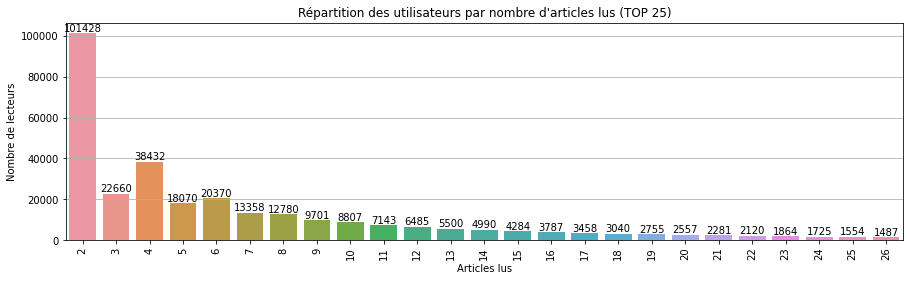

In [25]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])[:25]

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus (TOP 25)", 
    x_label="Articles lus", y_label="Nombre de lecteurs",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [26]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 5
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])
selection = selection[ selection.index >= min_reads]
selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection

print(f"{selection['num_users'].sum()} utilisateurs ({selection['num_users_percent'].sum():.2f}%) ont lus plus de {min_reads} articles")

160377 utilisateurs (49.67%) ont lus plus de 5 articles


> * On peut voir que tous les utilisateurs ont lus au moins 2 articles
> * On peut également noter que plus de **31% des utilisateurs n'ont lu que 2 articles**... ils ne sont peut être pas pertinents pour faire de la recommandation.
> * De même en pourcentage cumulé, plus de **50% des utilisateurs ont lus 4 articles ou moins**...
>>
> * En pourcentage cumulé, environ **50% des utilisateurs ont lus 5 articles ou plus**...
> * En pourcentage cumulé, environ **27% des utilisateurs ont lus 10 articles ou plus**...
> * En pourcentage cumulé, environ **2% des utilisateurs ont lus 50 articles ou plus**...
> * En pourcentage cumulé, environ **0.35% des utilisateurs ont lus 100 articles ou plus**...

### Regardons le nombre de lecteurs par article

total_reads             1       2       3       4      5      6      7      \
num_articles         24811.00 4682.00 2129.00 1315.00 990.00 746.00 621.00   
num_articles_percent    53.90   10.17    4.62    2.86   2.15   1.62   1.35   

total_reads           8      9      10     ...  19526  20303  21062  21577  \
num_articles         504.00 476.00 384.00  ...   1.00   1.00   1.00   1.00   
num_articles_percent   1.09   1.03   0.83  ...   0.00   0.00   0.00   0.00   

total_reads           21855  23122  23499  23851  28943  37213  
num_articles           1.00   1.00   1.00   1.00   1.00   1.00  
num_articles_percent   0.00   0.00   0.00   0.00   0.00   0.00  

[2 rows x 1185 columns]

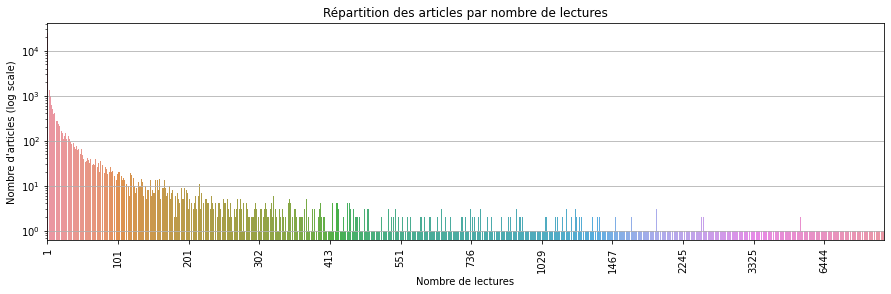

In [27]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures", 
    x_label="Nombre de lectures", y_label="Nombre d'articles (log scale)",
    labels_modulo=100, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

total_reads                1       2       3       4      5      6      7   \
num_articles         24811.00 4682.00 2129.00 1315.00 990.00 746.00 621.00   
num_articles_percent    53.90   10.17    4.62    2.86   2.15   1.62   1.35   

total_reads              8      9      10  ...     16     17     18     19  \
num_articles         504.00 476.00 384.00  ... 247.00 232.00 209.00 193.00   
num_articles_percent   1.09   1.03   0.83  ...   0.54   0.50   0.45   0.42   

total_reads              20     21     22     23     24     25  
num_articles         175.00 165.00 149.00 160.00 106.00 126.00  
num_articles_percent   0.38   0.36   0.32   0.35   0.23   0.27  

[2 rows x 25 columns]

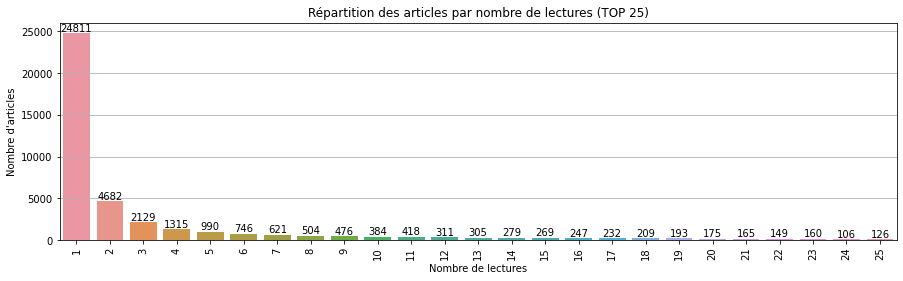

In [28]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles'])[:25] # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures (TOP 25)", 
    x_label="Nombre de lectures", y_label="Nombre d'articles",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [29]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 5
selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures
selection = selection[ selection.index >= min_reads]
selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection

print(f"{selection['num_articles'].sum()} articles ({selection['num_articles_percent'].sum():.2f}%) ont été lus au moins {min_reads} fois")

13096 articles (28.45%) ont été lus au moins 5 fois


In [30]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
display(selection.describe().T)
print(f"Le quartile 0.99 se situe à {int(selection.quantile(0.99))} articles lus")

count  mean    std  min  25%  50%  75%      max
total_reads 46033.00 64.91 629.32 1.00 1.00 1.00 6.00 37213.00

Le quartile 0.99 se situe à 1203 articles lus


> * Environ **54% des articles ont été lus une seule fois**...
> * En pourcentage cumulé, environ **75% des articles ont été lus 6 fois ou moins**.
>>
> * En pourcentage cumulé, environ **28% des articles ont été lus 5 fois ou plus**.
> * En pourcentage cumulé, environ **21% des articles ont été lus 10 fois ou plus**.
> * En pourcentage cumulé, environ **9% des articles ont été lus 50 fois ou plus**.
> * En pourcentage cumulé, environ **5% des articles ont été lus 100 fois ou plus**.
> * En pourcentage cumulé, environ **1% des articles ont été lus 1000 fois ou plus**.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les sessions dont la taille est atypique *(on supprime ce qui dépasse quartile(0.99))* ❓
>>
> - ✅ Supprimer les sessions dont les utilisateurs ont lus trop peu d'articles *(moins de 10 ? moins que le nombre d'articles à recommander ?)*<br>*(action: supprimé en section 4.2.2)*
> - ❌ Supprimer les sessions dont les utilisateurs ont lus trop d'articles *(on supprime ce qui dépasse quartile(0.99))* ❓
>>
> - ✅ Supprimer les sessions dont les articles n'ont été lus qu'une seule fois *(53.9%)*<br>*(action: supprimé en section 4.2.1)*
> - ❌ Supprimer les sessions dont les articles ont été lus trop souvent *(on supprime ce qui dépasse quartile(0.99) soit 1200 environ)* ❓

---
---
# 4. Préparation du jeu de données de travail <a class="anchor" id="dataset"></a> [⇪](#menu)

## 4.1 Fusion de `articles_metadata.csv` et `clicks_hour_xxx.csv` <a class="anchor" id="dataset_merge"></a> [⇪](#menu)

In [31]:
data_merge = pd.merge(data_clicks, data_articles, how='left', left_on='click_article_id', right_on='article_id')
display(data_merge.head(), data_merge.shape)

user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   
1        0  1506825423271737  1506825423000             2             68866   
2        1  1506825426267738  1506825426000             2            235840   
3        1  1506825426267738  1506825426000             2             96663   
4        2  1506825435299739  1506825435000             2            119592   

   click_timestamp click_environment click_deviceGroup click_os click_country  \
0    1506826828020                 4                 3       20             1   
1    1506826858020                 4                 3       20             1   
2    1506827017951                 4                 1       17             1   
3    1506827047951                 4                 1       17             1   
4    1506827090575                 4                 1       17             1   

  click_region click_referrer_type  hour  article_id  category_id  \
0           20                   2     0      157541          281   
1           20                   2     0       68866          136   
2           16                   2     0      235840          375   
3           16                   2     0       96663          209   
4           24                   2     0      119592          247   

   created_at_ts  publisher_id  words_count  
0  1506800518000             0          280  
1  1506816482000             0          226  
2  1506807839000             0          159  
3  1506788025000             0          206  
4  1506784316000             0          239

(2988181, 18)

### Vérifions la taille de la jointure

In [32]:
print("data_article.shape:", data_articles.shape, "\ndata_clicks.shape:", data_clicks.shape, "\ndata_merge.shape:", data_merge.shape)

data_article.shape: (364047, 5) 
data_clicks.shape: (2988181, 13) 
data_merge.shape: (2988181, 18)


> On a donc bien un dataset_merge qui à le même nombre de lignes que data_clicks et un nombre de colonnes égale à l'ensemble des colonnes des deux datasets

### Vérifions le contenu de la jointure

In [33]:
index = 0

In [34]:
pd.DataFrame(data_merge.iloc[index]).T

user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   

   click_country  click_region  click_referrer_type  hour  article_id  \
0              1            20                    2     0      157541   

   category_id  created_at_ts  publisher_id  words_count  
0          281  1506800518000             0          280

In [35]:
pd.DataFrame(data_clicks.iloc[index]).T

user_id        session_id  session_start  session_size  click_article_id  \
0        0  1506825423271737  1506825423000             2            157541   

   click_timestamp  click_environment  click_deviceGroup  click_os  \
0    1506826828020                  4                  3        20   

   click_country  click_region  click_referrer_type  hour  
0              1            20                    2     0

In [36]:
data_articles[ data_articles.article_id == data_clicks.iloc[index].click_article_id ]

article_id  category_id  created_at_ts  publisher_id  words_count
157541      157541          281  1506800518000             0          280

> Visiblement la jointure s'est bien passée, et on a les bons articles associés aux sessions

In [37]:
data_merge.drop(['click_article_id'], axis=1, inplace=True)
data_merge.head(1)

user_id        session_id  session_start  session_size  click_timestamp  \
0        0  1506825423271737  1506825423000             2    1506826828020   

  click_environment click_deviceGroup click_os click_country click_region  \
0                 4                 3       20             1           20   

  click_referrer_type  hour  article_id  category_id  created_at_ts  \
0                   2     0      157541          281  1506800518000   

   publisher_id  words_count  
0             0          280

## 4.2 Nettoyage du jeu de données <a class="anchor" id="dataset_clean"></a> [⇪](#menu)

In [38]:
data_clean = data_merge.copy()

### 4.2.1 Supprimons les sessions liées aux articles lus une seule fois *(moins de 2 lectures)*

In [39]:
min_clicks_articles = 5

In [40]:
count_articles_clicks = data_clean.groupby(['article_id']).size()
count_articles_clicks.head(5)

article_id
3     1
27    1
69    1
81    2
84    1
dtype: int64

In [41]:
size_before = data_clean.shape

select_ids = [k for k,v in count_articles_clicks.iteritems() if v >= min_clicks_articles]
data_clean = data_clean[ data_clean.article_id.isin(select_ids) ]
display(data_clean.sample(3, random_state=random_seed), data_clean.shape)

size_after = data_clean.shape
print(f"\nTaille AVANT nettoyage: {size_before} | Taille APRÈS nettoyage: {size_after}\nSoit une différence de {size_after[0]-size_before[0]} lignes et {size_after[1] - size_before[1]} colonnes.")

user_id        session_id  session_start  session_size  \
1320827   216846  1507373080247102  1507373080000             3   
236295       667  1506958710272502  1506958710000             2   
1628173   243758  1507559801157490  1507559801000             2   

         click_timestamp click_environment click_deviceGroup click_os  \
1320827    1507373417487                 4                 3        2   
236295     1506958769090                 4                 3        2   
1628173    1507559856479                 4                 1       17   

        click_country click_region click_referrer_type  hour  article_id  \
1320827             1           13                   2   152      158906   
236295              1           25                   2    37      300470   
1628173             1           13                   1   204      255202   

         category_id  created_at_ts  publisher_id  words_count  
1320827          281  1507352459000             0          289  
236295           428  1506943705000             0          203  
1628173          389  1507547619000             0          188

(2942359, 17)


Taille AVANT nettoyage: (2988181, 17) | Taille APRÈS nettoyage: (2942359, 17)
Soit une différence de -45822 lignes et 0 colonnes.


#### Vérifions que le nettoyage s'est bien passé

In [42]:
selection = data_clean[['user_id','article_id']].copy()

selection = pd.DataFrame(selection.groupby('article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures
selection = selection[ selection.index >= min_clicks_articles]
selection["num_articles_percent"] = 100 / data_clean['article_id'].nunique() * selection

print(f"{selection['num_articles_percent'].sum():.2f}% des articles ont été lus au moins {min_clicks_articles} fois")

100.00% des articles ont été lus au moins 5 fois


### 4.2.2 Supprimons les sessions des utilisateurs peu actifs *(moins de 5 lectures)*

In [43]:
min_clicks_users = 5

In [44]:
count_users_clicks = data_clean.groupby(['user_id']).size()
count_users_clicks.head(5)

user_id
0     8
1    12
2     4
3    17
4     7
dtype: int64

In [45]:
size_before = data_clean.shape

select_ids = [k for k,v in count_users_clicks.iteritems() if v >= min_clicks_users]
# data_clean = data_clean[ data_clean.user_id.isin(select_ids) ]
data_clean["TO_DELETE"] = ~(data_clean.user_id.isin(select_ids))
display(data_clean.head(5), data_clean.shape)

size_after = data_clean.shape
print(f"\nTaille AVANT nettoyage: {size_before} | Taille APRÈS nettoyage: {size_after}\nSoit une différence de {size_after[0]-size_before[0]} lignes et {size_after[1] - size_before[1]} colonnes.")

user_id        session_id  session_start  session_size  click_timestamp  \
0        0  1506825423271737  1506825423000             2    1506826828020   
1        0  1506825423271737  1506825423000             2    1506826858020   
2        1  1506825426267738  1506825426000             2    1506827017951   
3        1  1506825426267738  1506825426000             2    1506827047951   
4        2  1506825435299739  1506825435000             2    1506827090575   

  click_environment click_deviceGroup click_os click_country click_region  \
0                 4                 3       20             1           20   
1                 4                 3       20             1           20   
2                 4                 1       17             1           16   
3                 4                 1       17             1           16   
4                 4                 1       17             1           24   

  click_referrer_type  hour  article_id  category_id  created_at_ts  \
0                   2     0      157541          281  1506800518000   
1                   2     0       68866          136  1506816482000   
2                   2     0      235840          375  1506807839000   
3                   2     0       96663          209  1506788025000   
4                   2     0      119592          247  1506784316000   

   publisher_id  words_count  TO_DELETE  
0             0          280      False  
1             0          226      False  
2             0          159      False  
3             0          206      False  
4             0          239       True

(2942359, 18)


Taille AVANT nettoyage: (2942359, 17) | Taille APRÈS nettoyage: (2942359, 18)
Soit une différence de 0 lignes et 1 colonnes.


#### Vérifions que le marquage s'est bien passé

In [46]:
selection = data_clean[['user_id','article_id', 'TO_DELETE']].copy()
selection_ref = selection[ selection['TO_DELETE'] == False ]

selection = pd.DataFrame(selection_ref.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])
selection = selection[ selection.index >= min_clicks_users]
selection["num_users_percent"] = 100 / selection_ref['user_id'].nunique() * selection

print(f"{selection['num_users'].sum()} utilisateurs ({selection['num_users_percent'].sum():.2f}%) ont lus {min_clicks_users} articles ou plus")

158535 utilisateurs (100.00%) ont lus 5 articles ou plus


## 4.3 Conception d'une feature de scoring <a class="anchor" id="dataset_score"></a> [⇪](#menu)

Pour concevoir un score lié à chaque paire utilisateur/news on a plusieurs options:
- un score basé sur le nombre de fois que l'utilisateur a consulté la news
- un score basé sur le temps écoulé entre 2 clicks (ça veut dire qu'il faut des sessions de 2+ clicks et que l'on ne pourra pas prendre en compte le dernier click)
- un score basé sur le temps écoulé entre 2 clicks (voir ci-dessous) et en fonction du nombre de mots dans l'article
- un score basé sur la catégorie de l'article (un visiteur qui click plus sur les articles de certaines catégories est plus suceptible de le faire encore)

Essayons de construire les 3 scores et on vera ensuite celui qui semble le plus intéressant

### 4.3.1 Score basé sur le nombre de visite utilisateur

In [47]:
selection = data_clean[['user_id', 'article_id', 'TO_DELETE']].copy()
selection = selection[ selection['TO_DELETE'] == False ]
selection = pd.DataFrame(selection.groupby(['user_id', 'article_id']).size(), columns=['score'])
selection.T

user_id    0                                                       1       \
article_id 68866  87205  87224  96755  157541 160158 233470 313996 36162    
score           1      1      1      1      1      1      1      1      1   

user_id            ... 322732                             322823         \
article_id 59758   ... 156279 205824 209122 211442 284470 39894  277107   
score           1  ...      1      1      1      1      1      1      1   

user_id                          
article_id 308117 342473 352979  
score           1      1      1  

[1 rows x 2488481 columns]

In [48]:
data_score1 = pd.merge(data_clean, selection, how='left', on=['user_id','article_id'])
data_score1 = data_score1[ data_score1['TO_DELETE'] == False ]
data_score1.drop('TO_DELETE', axis=1, inplace=True)
display(data_score1.sample(3, random_state=random_seed), data_score1.shape)

user_id        session_id  session_start  session_size  \
1443972      681  1507475777380625  1507475777000            11   
1250579    58907  1507332587243342  1507332587000             3   
2484665    28315  1507910451189004  1507910451000             3   

         click_timestamp click_environment click_deviceGroup click_os  \
1443972    1507477378267                 4                 4       20   
1250579    1507332600841                 4                 1       17   
2484665    1507910493599                 4                 1       17   

        click_country click_region click_referrer_type  hour  article_id  \
1443972             1           20                   1   180      341288   
1250579             1           24                   2   140       63737   
2484665             1           21                   2   301      236566   

         category_id  created_at_ts  publisher_id  words_count  score  
1443972          438  1507464948000             0          231   1.00  
1250579          133  1507281959000             0          131   1.00  
2484665          375  1507892201000             0          192   1.00

(2524552, 18)

score              1.00     2.00    3.00    4.00   5.00   6.00   7.00   8.00   \
count         2455910.00 60472.00 5409.00 1312.00 475.00 252.00 154.00 112.00   
count_percent      97.28     2.40    0.21    0.05   0.02   0.01   0.01   0.00   

score          9.00   10.00  12.00  13.00  16.00  17.00  30.00  31.00  33.00  
count          63.00  70.00  36.00  78.00  32.00  17.00  30.00  31.00  99.00  
count_percent   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

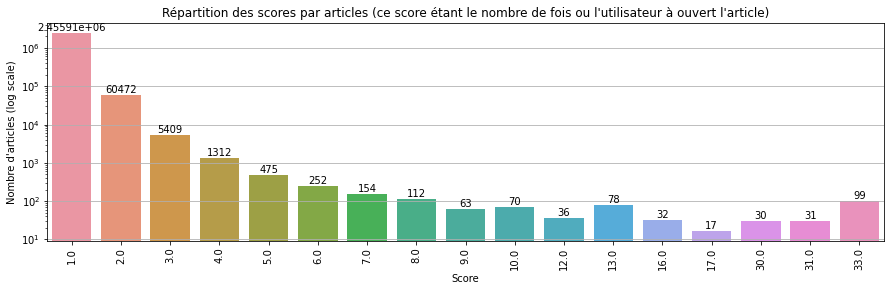

In [49]:
selection = data_score1[['session_id', 'score']].copy()
selection = pd.DataFrame(selection.groupby('score').size(), columns=['count'])

selection["count_percent"] = 100 / data_score1.shape[0] * selection
display(selection.T)
selection = selection[['count']].T

plot_bars(
    selection, 
    "Répartition des scores par articles (ce score étant le nombre de fois ou l'utilisateur à ouvert l'article)", 
    x_label="Score", y_label="Nombre d'articles (log scale)",
    labels_modulo=1, show_values=True, log_scale=True, show_grid=True, 
)

In [50]:
pd.DataFrame(data_score1.score.describe()).T

count  mean  std  min  25%  50%  75%   max
score 2524552.00  1.03 0.35 1.00 1.00 1.00 1.00 33.00

> ⚠️ Vu sa répartition, ce score ne semble pas très utile... *(plus de 97% des articles ont été visités une seule fois et ont donc un score de 1)*

### 4.3.2 Score basé sur le temps écoulé entre deux articles d'une même session
*(il faut des sessions de 2 articles mini, et le dernier sera perdu car on a pas de temps de cloture des sessions)*

In [ ]:
data_clean.head(1)

In [ ]:
data_clean[ data_clean.session_id == 1506825426267738 ]

In [ ]:
data_merge[ data_merge.session_id == 1506825426267738 ]

In [ ]:
selection = data_clean[['session_id', 'session_start', 'session_size', 'click_timestamp']].copy()
selection = pd.DataFrame(selection.groupby(['session_id', 'session_size', 'session_start', 'click_timestamp']))
selection

In [ ]:
for i, x in selection.iteritems():
    print(x)
    if i > 2 :
        break

### ???

In [ ]:
selection = data_clicks.session_size.value_counts()
print(data_clicks.shape)
selection = 100 / data_clicks.shape[0] * selection
selection = pd.DataFrame(selection).sort_index().T
selection
plot_bars(selection, "Répartition des tailles de sessions", labels_modulo=1, show_values=False)

In [ ]:
data_clicks[ data_clicks.user_id == 2 ]

* Quelle est le nombre moyen de sessions par utilisateurs ?
* Quelle est le nombre moyen d'interactions par session ?
* Combien d'articles sont 'relus' ?
* 

## Load clicks sample (1 Hour - id=000)

In [ ]:
data_clicks_1H = pd.read_csv('data/news-portal-user-interactions-by-globocom/clicks_sample.csv')
display(data_clicks_1H.head(), data_clicks_1H.shape)

In [ ]:
data_clicks_1H.describe(include='all')

## Load the Articles' Embedding

articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.

In [ ]:
file = open('data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle',"rb")
article_embedding = pickle.load(file)

In [ ]:
article_embedding

In [ ]:
article_embedding.shape